_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Name: *Harry Antony (5610172) | Nishad Singhi (5619175)*

# Coding Lab 5

If needed, download the data files ```nda_ex_5_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

mpl.rc("savefig", dpi=72)

from scipy import signal as signal

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
spikes = pd.read_csv('../data/nda_ex_5_spiketimes.csv') # neuron id, spike time
stims = pd.read_csv('../data/nda_ex_5_stimulus.csv')  # stimulus onset in ms, direction

stimDur = 2000.    # in ms
nTrials = 11       # number of trials per condition
nDirs = 16         # number of conditions
deltaDir = 22.5    # difference between conditions

stims['StimOffset'] = stims['StimOnset'] + stimDur

In [3]:
spikes

,Neuron,SpikeTimes
0,1,19.900000
1,1,29.866667
2,1,44.733333
3,1,55.033333
4,1,85.800000
...,...,...
223932,41,639602.133333
223933,41,639605.700000
223934,41,639638.266667
223935,41,639817.000000


In [4]:
stims

,StimOnset,Dir,StimOffset
0,15570,270.0,17570.0
1,19022,45.0,21022.0
2,22592,112.5,24592.0
3,26095,225.0,28095.0
4,29431,180.0,31431.0
...,...,...,...
171,583583,315.0,585583.0
172,586836,22.5,588836.0
173,590355,67.5,592355.0
174,593641,180.0,595641.0


We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [385]:
# you may add computations as specified above
num_spikes = spikes.shape[0]
relTime = np.zeros(num_spikes)
Dir = np.full(num_spikes, -1, dtype=np.float32)  # np.ones(num_spikes)*(-1)
Trial = np.full(num_spikes, -1)
trial_count = np.ones(nDirs)
stimPeriod = np.zeros(num_spikes) # remove this

spike_timings = np.array(spikes['SpikeTimes'])

for stim_idx in range(stims.shape[0]):
    onset_time = stims.loc[stim_idx]['StimOnset']
    offset_time = stims.loc[stim_idx]['StimOffset']
    
    stim_spike_idx = np.argwhere(np.logical_and(spike_timings > onset_time - 100, spike_timings < offset_time + 100))
        
    relTime[stim_spike_idx] = spike_timings[stim_spike_idx] - onset_time
    direction = stims.loc[stim_idx]['Dir']
    Dir[stim_spike_idx] = direction

    # you may copy these two lines if its not intuitive
    Trial[stim_spike_idx] = trial_count[int(direction/deltaDir)]
    trial_count[int(direction/deltaDir)] += 1
    
    # ignore these two lines
    in_stim_period = np.argwhere(np.logical_and(spike_timings >= onset_time, spike_timings <= offset_time))
    stimPeriod[in_stim_period] = 1
    
# we made 3 or 4 np.arrays, now we will transfer this data into the 'spikes' dataframe
spikes['Trial'] = Trial
spikes['Dir'] = Dir
spikes['relTime'] = relTime
spikes['stimPeriod'] = stimPeriod # ignore

In [386]:
spikes

,Neuron,SpikeTimes,Trial,Dir,relTime,stimPeriod
0,1,19.900000,-1,-1.0,0.0,0.0
1,1,29.866667,-1,-1.0,0.0,0.0
2,1,44.733333,-1,-1.0,0.0,0.0
3,1,55.033333,-1,-1.0,0.0,0.0
4,1,85.800000,-1,-1.0,0.0,0.0
...,...,...,...,...,...,...
223932,41,639602.133333,-1,-1.0,0.0,0.0
223933,41,639605.700000,-1,-1.0,0.0,0.0
223934,41,639638.266667,-1,-1.0,0.0,0.0
223935,41,639817.000000,-1,-1.0,0.0,0.0


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [399]:
def plotRaster(spikes, neuron):
    #    Plot spike rasters for a single neuron sorted by condition
    #
    #    spikes    pandas dataframe with columns 
    #                  Neuron
    #                  SpikeTimes
    #                  Dir
    #                  relTime
    #                  Trial
    #                  stimPeriod
    #    neuron    scalar

    neuron_spikes = spikes[spikes['Neuron'] == neuron]  # extract the data corresponding to the given neuron
    all_dirs = np.arange(360-deltaDir, -deltaDir, -deltaDir)
    
    fig, ax = plt.subplots(np.size(all_dirs), 1, sharex=True, figsize=(10, 10))
    
    for i in range(np.size(all_dirs)):
        dir_spikes = neuron_spikes[neuron_spikes['Dir'] == all_dirs[i]] # extract the data for the given direction and neuron
        # ax[i] -- ith subplot
        ax[i].scatter(dir_spikes['relTime'], dir_spikes['Trial'], s=2) # s = 2 defines the size of points
        
        # just copy this - decoration
        ax[i].set_ylim(0, nTrials+1) # this sets the range on the y-axis 
        ax[i].set_yticks([]) # this removes the values on the y-axis
        ax[i].set_ylabel(str(all_dirs[i]), fontsize=10) # this prints the value of the direction for each subplot

    ax[nDirs-1].set_xlabel("Relative time (ms)", fontsize=12)
    ax[0].set_title("Raster plots for each direction of stimulus for neuron {}".format(neuron), fontsize=12)
    plt.subplots_adjust(hspace=0)

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

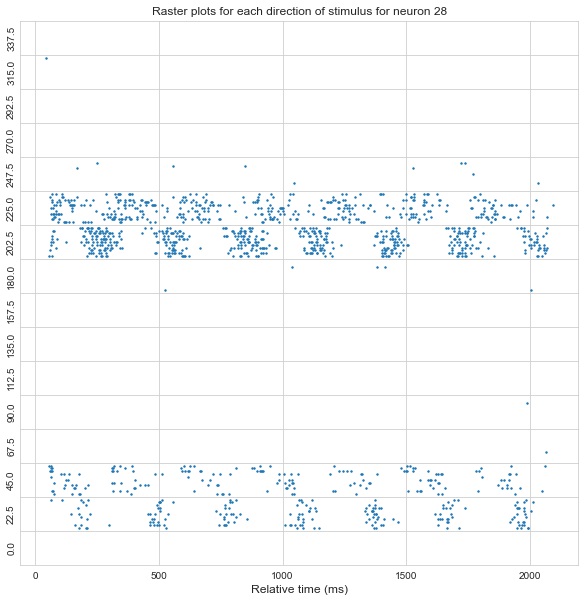

In [401]:
plotRaster(spikes, 28)

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

Remark: a simple histogram is not enough here.

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


In [412]:
def plotPSTH(spikes, neuron):
    #    Plot PSTH for a single neuron sorted by condition
    #
    #    spikes    pandas dataframe with columns 
    #                  Neuron
    #                  SpikeTimes
    #                  Dir
    #                  relTime
    #                  Trial
    #                  stimPeriod
    #    neuron    scalar

    bin_size = 15
    num_bins = int((stimDur + 200)/bin_size)
    
    neuron_spikes = spikes[spikes['Neuron'] == neuron]
    all_dirs = np.arange(360-deltaDir, -deltaDir, -deltaDir)
    
    fig, ax = plt.subplots(np.size(all_dirs), 1, sharex=True, sharey=True, figsize=(10, 10))
    
    for i in range(np.size(all_dirs)):
        dir_spikes = neuron_spikes[neuron_spikes['Dir'] == all_dirs[i]]
        freq, bins = np.histogram(dir_spikes['relTime'], bins=num_bins)
        ax[i].bar(bins[:-1], np.divide(freq, nTrials), width=bin_size, edgecolor="none")

        ax[i].grid(False)
        ax[i].set_ylabel(str(all_dirs[i]), fontsize=10)
        
    ax[nDirs-1].set_xlabel("Relative time (ms)", fontsize=12)
    ax[0].set_title("PSTH for Neuron {}".format(neuron), fontsize=12)
    plt.subplots_adjust(hspace=0)

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

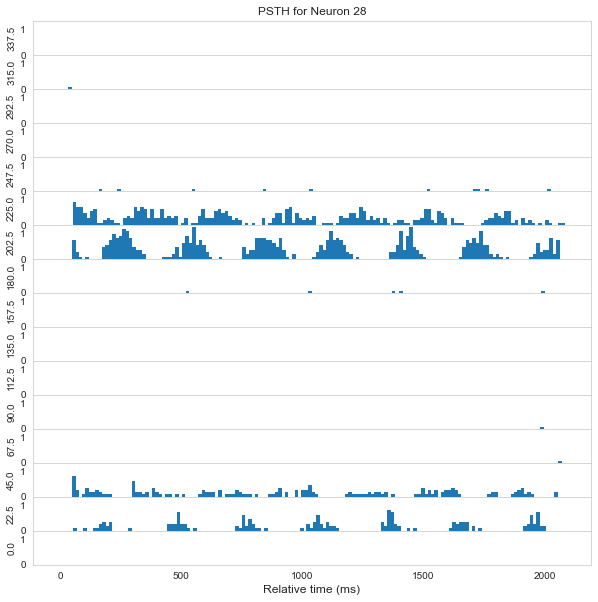

In [413]:
plotPSTH(spikes, 28)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi)))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [151]:
def vonMises(theta, alpha, kappa, nu, phi):
#     # Evaluate the parametric von Mises tuning curve with parameters p at locations theta. 
#     # The locations are given in degrees, not radians.
#     #
#     #   theta:  1 by N
#     #   alpha, kappa, nu, phi:   parameters of the function
#     #
#     #   f:      1 by N
    f = np.exp(alpha + kappa*(np.cos(2*(theta*(np.pi/180) - phi) - 1) + nu*(np.cos(theta*(np.pi/180) - phi) - 1))
    
    return f

Plot the von Mises function while varying the parameters systematically.

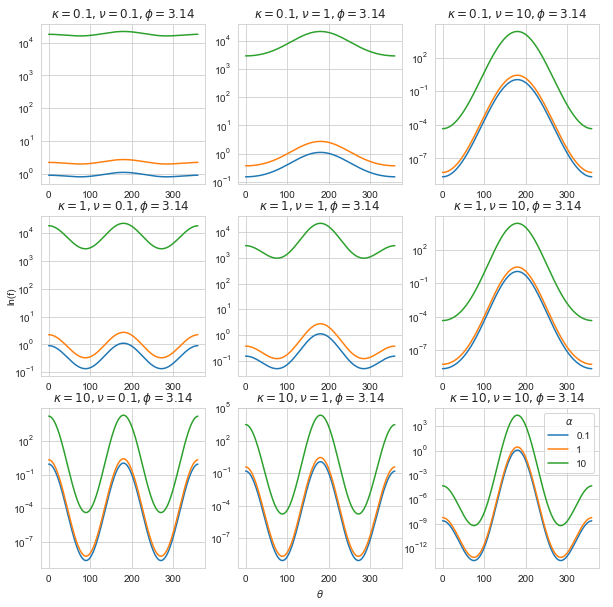

In [156]:
x = np.arange(0,360)

all_values = (0.1, 1, 10)
phi = np.pi

fig = plt.figure(figsize=(10, 10))

for row, kappa in enumerate(all_values):
    for col, nu in enumerate(all_values):
        ax = plt.subplot2grid((3, 3), (row, col))
        for alpha in all_values:
            ax.plot(x, vonMises(x, alpha, kappa, nu, phi), label=alpha)
            ax.set_yscale('log')
            ax.set_title(r"$\kappa = {}, \nu = {}, \phi = {}$".format(kappa, nu, round(phi, 2)))

plt.legend(title=r'$\alpha$')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"$\theta$")
plt.ylabel("ln(f)")
plt.grid(False)

In [414]:
def tuningCurve(counts, dirs, show):
    '''
    Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.
    Plot the data if show is True, otherwise just return the fit.
        count      #trials x 1, contains the spike count during the stimulation period
        dirs       #trials x 1, contains the direction in degrees
        show       Boolean, indicates whether a plot is generated

        p          1 by 4 parameter vector of tuning curve function
    '''
    p,cov = opt.curve_fit(vonMises, dirs, counts)

    if show:
        fig = plt.figure(figsize=(10, 5))  # just to set the size
        
        # plot red points
        plt.scatter(dirs, counts, color='red')
        
        # plot blue line
        x = np.arange(0,360)
        y = vonMises(x, p[0], p[1], p[2], p[3])
        plt.plot(x, y)
        plt.xlabel(r"Direction $\theta$ (degrees)")
        plt.ylabel("Spike counts")
        return p

    else:
        return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

Text(0.5, 1.0, 'Tuning curve fitting for neuron 28')

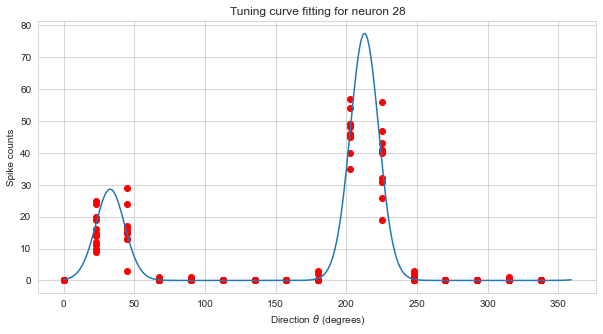

In [415]:
neuron = 28

all_dirs = np.arange(0, 360, deltaDir)
counts_matrix = np.zeros((nTrials, nDirs))
dirs_matrix = np.zeros((nTrials, nDirs))

for i in range(nTrials):
    for j in range(nDirs):
        neuron_spikes = spikes[spikes['Neuron'] == neuron]
        direction_spikes = neuron_spikes[neuron_spikes['Dir'] == all_dirs[j]]
        trial_spikes = direction_spikes[direction_spikes['Trial'] == i+1] # trial starts from 1
        counts_matrix[i, j] = trial_spikes.shape[0]
        dirs_matrix[i, j] = all_dirs[j]

counts = counts_matrix.flatten()
dirs = dirs_matrix.flatten()

tuningCurve(counts, dirs, True)
plt.title(f"Tuning curve fitting for neuron {neuron}")


Text(0.5, 1.0, 'Tuning curve fitting for neuron 37')

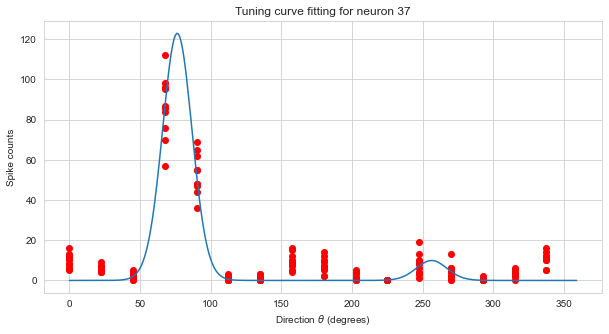

In [416]:
neuron = 37

# more code here
all_dirs = np.arange(0, 360, deltaDir)
counts_matrix = np.zeros((nTrials, nDirs))
dirs_matrix = np.zeros((nTrials, nDirs))

for i, trial in enumerate(range(1, nTrials+1)):
    for j, direction in enumerate(all_dirs):
        neuron_spikes = spikes[spikes['Neuron'] == neuron]
        direction_spikes = neuron_spikes[neuron_spikes['Dir'] == direction]
        trial_spikes = direction_spikes[direction_spikes['Trial'] == trial]
        counts_matrix[i, j] = trial_spikes.shape[0]
        dirs_matrix[i, j] = direction

counts = counts_matrix.flatten()
dirs = dirs_matrix.flatten()
    
tuningCurve(counts,dirs, True)
plt.title(f"Tuning curve fitting for neuron {neuron}")


## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [428]:
def testTuning(dirs, counts, psi=1, show=False):
    """
    Plot the data if show is True, otherwise just return the fit.
        count      #trials x #directions, contains the spike count during the stimulation period
        dirs       #trials x #directions, contains the direction in degrees
        psi        fourier component to test (1 = direction, 2 = orientation)
        show       Boolean, indicates whether a plot is generated
    
        p       p-value
        q       magnitude of second Fourier component
        qdistr  sampling distribution of |q| under the null hypothesis    

    """
    num_iters = 1000
    
    all_dirs = np.arange(0, 360, deltaDir)
    all_dirs_rad = all_dirs * (np.pi/180)
    
    def q_mod(X):
        v = np.exp(psi*1j*all_dirs_rad)
        m = np.mean(X, axis=0)
        q = m@v  # @: matrix multiplication
        
        return np.abs(q)
    
    q = q_mod(counts)  # this is the red line
    
    qdistr = np.zeros(num_iters)
    randcounts = np.zeros(counts.shape)
    for i in range(num_iters):
        for trial in range(nTrials):
            randind = np.random.permutation(range(nDirs))  # this is a randomly generated order of all the values in a row
            randcounts[trial] = counts[trial, randind]
        qdistr[i] = q_mod(randcounts)
    
    p = np.size(np.argwhere(qdistr > q))/num_iters
            
    if show:
        fig = plt.figure(figsize=(8, 5)) # to define the size of the plot
        sns.distplot(qdistr) # to plot the histogram and the blue line
        plt.axvline(q, color='r') # to plot the red line
        plt.ylabel("Density")
        plt.xlabel("|q|")
        plt.text(q, 0.01, f"|q| = {round(q, 2)}", backgroundcolor='white') # plt.text(x_coordinate, y_coordinate, text)
        plt.title(f"p = {p}")
      
    else:
        return p, q, qdistr

Show null distribution for the example cell:

/Users/nsinghi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Histogram of PDF of |q| for neuron 9')

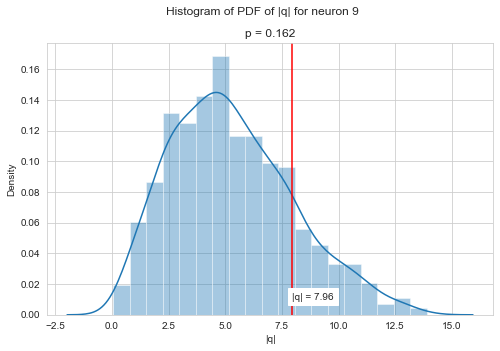

In [430]:
neuron = 9

counts = np.zeros((nTrials, nDirs))
dirs = np.zeros((nTrials, nDirs))

for i, trial in enumerate(range(1, nTrials+1)):
    for j, direction in enumerate(all_dirs):
        neuron_spikes = spikes[spikes['Neuron'] == neuron]
        direction_spikes = neuron_spikes[neuron_spikes['Dir'] == direction]
        trial_spikes = direction_spikes[direction_spikes['Trial'] == trial]
        counts[i, j] = trial_spikes.shape[0]
        dirs[i, j] = direction

testTuning(dirs,counts,show=True,psi=2)
plt.suptitle(f"Histogram of PDF of |q| for neuron {neuron}")

Test all cells for orientation and direction tuning

In [364]:
num_cells = np.size(np.unique(spikes['Neuron']))
p_dir = np.zeros(num_cells)
p_ori = np.zeros(num_cells)

for cell in range(num_cells):
    dirs, counts = prepare_counts(cell)
    p_dir[cell], _, _ = testTuning(dirs, counts, psi=1, show=False)
    p_ori[cell], _, _ = testTuning(dirs, counts, psi=2, show=False)

Number of direction tuned neurons:

In [365]:
np.sum(p_dir<0.01)

13

Number of orientation tuned neurons:

In [366]:
np.sum(p_ori<0.01)

34